In [32]:
# Imports
# Load the TensorBoard notebook extension
import cv2
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [33]:
# Declare preprocessing functions
tf.random.set_seed(999)
img_size = 128
def get_label(file_path: str):
    parsed = tf.strings.split(file_path, os.path.sep)
    parent = parsed[-2]
    return tf.argmax(parent == class_names)


def decode_img(img):
    
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_image(img, channels=3, dtype= tf.dtypes.uint8)

    # Check the number of channels
    num_channels = tf.shape(img)[-1]

    # Convert grayscale to RGB if necessary
    if num_channels == 1:
        print("grayscale")
        img = np.repeat(img, 3, axis=-1)
    # get image dimensions
    img_shape = tf.shape(img).numpy()

    width, height = img_shape[0], img_shape[1]
    min_dimension = tf.math.minimum(width, height).numpy()

    crop_size = tf.constant([min_dimension, min_dimension, 3], dtype='int32')
    # Implement random cropping
    img = tf.image.random_crop(value=img, size=crop_size)
    img = tf.cast(img, tf.float32)/255 # Explicitly cast to float32 and normalize
    return tf.image.resize(img, [img_size, img_size], method='nearest', preserve_aspect_ratio=False)


@tf.function
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.py_function(decode_img, [img], tf.float32)
    return img, label


In [34]:



# path_to_dir = os.environ.get("DATASET_PATH")
path_to_dir = "/Volumes/KINGSTON/Curated X-Ray Dataset"
if path_to_dir is None:
    os.environ["DATASET_PATH"] = input("Enter complete path to the chest_xray folder: ")
    path_to_dir = os.environ["DATASET_PATH"]
    print("You should set the DATASET_PATH enviroment variable to avoid this every time you run the program.")


normal = [str(file.absolute()) for file in pathlib.Path(path_to_dir).glob("Normal/[!._]*.jp*g")]
bacteria = [str(file.absolute()) for file in pathlib.Path(path_to_dir).glob("Pneumonia-Bacterial/[!._]*.jp*g")]
virus = [str(file.absolute()) for file in pathlib.Path(path_to_dir).glob("Pneumonia-Viral/[!._]*.jp*g")]
covid = [str(file.absolute()) for file in pathlib.Path(path_to_dir).glob("COVID-19/[!._]*.jp*g")]
ds_files = normal[:1281] + bacteria[:1281] + virus[:1281] + covid

list_ds = tf.data.Dataset.from_tensor_slices(ds_files)
image_count = len(ds_files)
print(image_count)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

for f in list_ds.take(5):
    print(f.numpy())

class_names = [os.path.basename(folder) for folder in pathlib.Path(path_to_dir).glob('[!._]*/')]
print(class_names)

val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)







5124
b'/Volumes/KINGSTON/Curated X-Ray Dataset/Pneumonia-Viral/Pneumonia-Viral (27).jpg'
b'/Volumes/KINGSTON/Curated X-Ray Dataset/COVID-19/COVID-19 (410).jpg'
b'/Volumes/KINGSTON/Curated X-Ray Dataset/Normal/Normal (1955).jpg'
b'/Volumes/KINGSTON/Curated X-Ray Dataset/Normal/Normal (1401).jpg'
b'/Volumes/KINGSTON/Curated X-Ray Dataset/COVID-19/COVID-19 (677).jpg'
['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']


Image shape:  (128, 128, 3)
Label:  2
Label Shape:  ()
Type:  Pneumonia-Bacterial


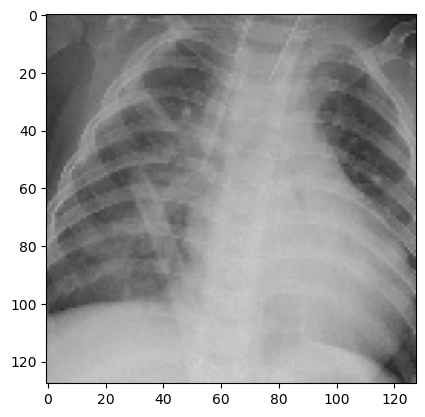

Image shape:  (128, 128, 3)
Label:  1
Label Shape:  ()
Type:  Normal


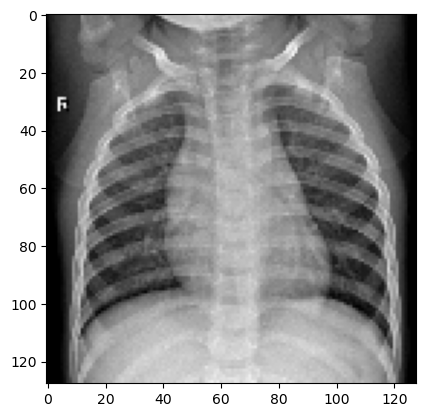

Image shape:  (128, 128, 3)
Label:  0
Label Shape:  ()
Type:  COVID-19


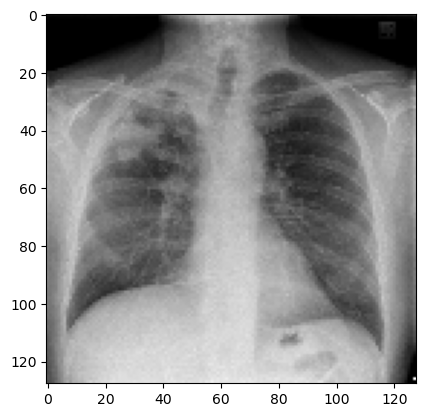

In [35]:
# View sample of dataset

for image, label in train_ds.take(3):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    print("Label Shape: ", label.numpy().shape)
    print("Type: ", class_names[label.numpy()])
    plt.imshow(image.numpy())
    plt.show()





In [36]:
# Sample model using MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint

In [37]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable=False
model = models.Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(len(class_names), activation='softmax'))



model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Func  (None, 4, 4, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_3  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 2586948 (9.87 MB)
Trainable params: 3289

In [38]:


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
# Batching
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

print('Training set size: ', len(train_ds)*batch_size)
print('Validation set size: ', len(val_ds)*batch_size)

# Define callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('xray_model.keras', save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')

# Define number of epochs and steps per epoch
epochs = 20
steps_per_epoch = len(train_ds)
validation_steps = len(val_ds) 

print(steps_per_epoch)


# Train the model using model.fit
history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds, validation_steps=validation_steps,
                    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback])





Training set size:  4160
Validation set size:  1024
65
Epoch 1/20
65/65 [==============================] - 51s 774ms/step - loss: 0.6755 - accuracy: 0.7273 - val_loss: 0.4212 - val_accuracy: 0.8379
Epoch 2/20
65/65 [==============================] - 50s 770ms/step - loss: 0.4766 - accuracy: 0.8012 - val_loss: 0.3699 - val_accuracy: 0.8438
Epoch 3/20
65/65 [==============================] - 50s 770ms/step - loss: 0.4313 - accuracy: 0.8212 - val_loss: 0.3410 - val_accuracy: 0.8545
Epoch 4/20
65/65 [==============================] - 50s 771ms/step - loss: 0.4061 - accuracy: 0.8315 - val_loss: 0.3371 - val_accuracy: 0.8584
Epoch 5/20
65/65 [==============================] - 50s 770ms/step - loss: 0.3883 - accuracy: 0.8354 - val_loss: 0.3155 - val_accuracy: 0.8662
Epoch 6/20
65/65 [==============================] - 50s 770ms/step - loss: 0.3551 - accuracy: 0.8485 - val_loss: 0.3091 - val_accuracy: 0.8779
Epoch 7/20
65/65 [==============================] - 50s 768ms/step - loss: 0.3428 - acc

In [39]:


test_loss, test_acc = model.evaluate(val_ds, verbose=2)




16/16 - 10s - loss: 0.2886 - accuracy: 0.8818 - 10s/epoch - 598ms/step


16/16 [==============================] - 10s 592ms/step
                     precision    recall  f1-score   support

           COVID-19     0.9856    0.9750    0.9803       280
             Normal     0.9745    0.9542    0.9642       240
Pneumonia-Bacterial     0.7385    0.8394    0.7857       249
    Pneumonia-Viral     0.7948    0.7137    0.7521       255

           accuracy                         0.8721      1024
          macro avg     0.8733    0.8706    0.8706      1024
       weighted avg     0.8754    0.8721    0.8724      1024



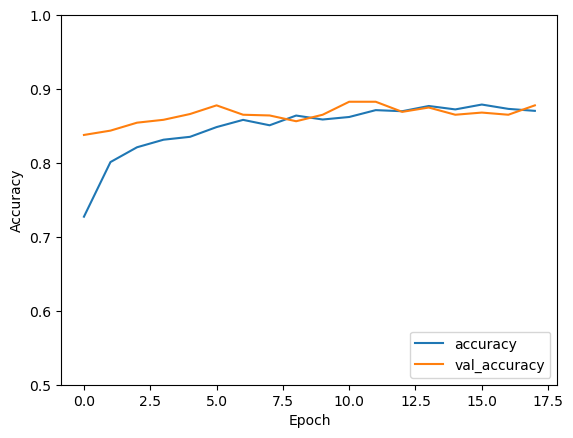

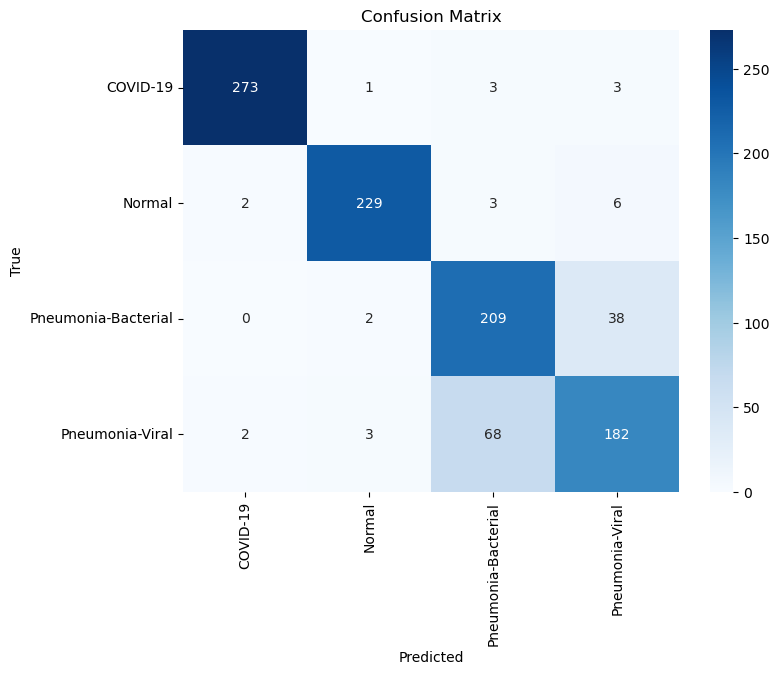

In [40]:
# Metrics



def val_metrics():
    y_pred_probabilities = model.predict(val_ds)
    y_true = [label.numpy() for _, label in val_ds]
    y_true = np.concatenate(y_true, axis=0)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')

    y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
    confusion = confusion_matrix(y_true, y_pred_classes)
    report = classification_report(y_true, y_pred_classes, target_names=class_names, digits=4)
    print(report)

    # Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
val_metrics()

In [41]:
model.save("xray_model.keras")

In [42]:
## Now, let's train all layers to fine tune!
model.load_weights("xray_model_post_train2.keras")
for layer in model.layers:
    layer.trainable = True

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.000000001,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True)


model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

epochs = 2

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('xray_model_fine_tuned', save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')


# Train the model using model.fit
history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds, validation_steps=validation_steps,
                    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback])
test_loss, test_acc = model.evaluate(val_ds, verbose=2)


Epoch 1/100
65/65 [==============================] - 61s 904ms/step - loss: 5.1388 - accuracy: 0.3095 - val_loss: 0.2401 - val_accuracy: 0.8994
Epoch 2/100
65/65 [==============================] - 65s 991ms/step - loss: 5.0727 - accuracy: 0.3073 - val_loss: 0.2623 - val_accuracy: 0.8857
Epoch 3/100
65/65 [==============================] - 74s 1s/step - loss: 5.1067 - accuracy: 0.3063 - val_loss: 0.2873 - val_accuracy: 0.8750
Epoch 4/100
65/65 [==============================] - 2391s 37s/step - loss: 5.0628 - accuracy: 0.3066 - val_loss: 0.3795 - val_accuracy: 0.8506
Epoch 5/100
65/65 [==============================] - 60s 903ms/step - loss: 5.0709 - accuracy: 0.3141 - val_loss: 0.4344 - val_accuracy: 0.8369
Epoch 6/100
65/65 [==============================] - 60s 903ms/step - loss: 5.1348 - accuracy: 0.3102 - val_loss: 0.5146 - val_accuracy: 0.8115
Epoch 7/100
65/65 [==============================] - 60s 914ms/step - loss: 5.2030 - accuracy: 0.2966 - val_loss: 0.6409 - val_accuracy: 0.

16/16 [==============================] - 10s 651ms/step
                     precision    recall  f1-score   support

           COVID-19     0.9790    1.0000    0.9894       280
             Normal     0.9915    0.9750    0.9832       240
Pneumonia-Bacterial     0.7895    0.8434    0.8155       249
    Pneumonia-Viral     0.8390    0.7765    0.8065       255

           accuracy                         0.9004      1024
          macro avg     0.8998    0.8987    0.8987      1024
       weighted avg     0.9010    0.9004    0.9001      1024



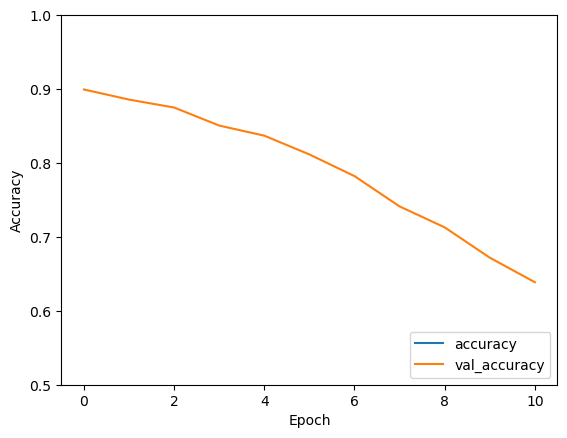

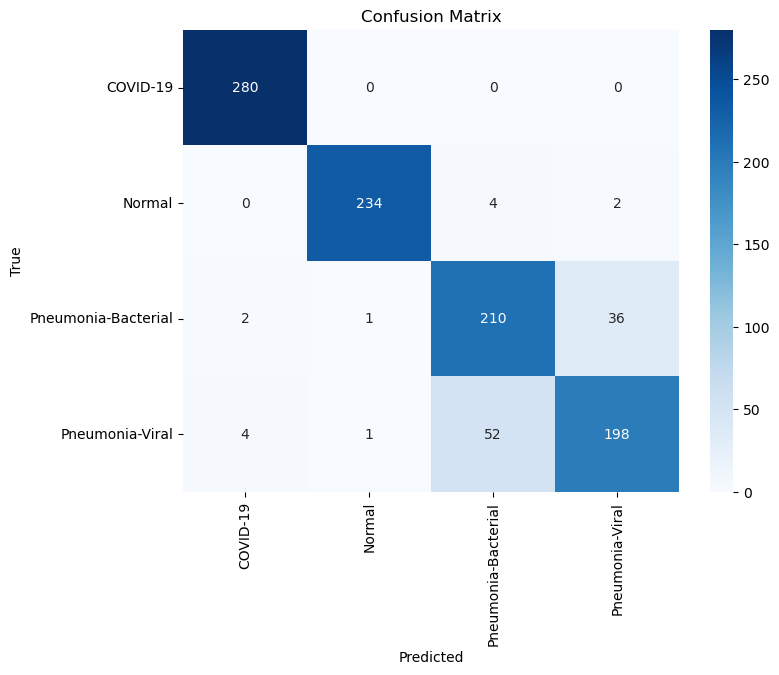

In [45]:
val_metrics()
model.save("xray_model_fine_tuned.keras")

In [46]:
# Call me Icarus the way I'm flying too close to the sun rn. I'm going to try to freeze the mobilenet layers again and fine tune even further. 

model.load_weights("xray_model_fine_tuned.keras")
for layer in model.layers[:-4]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

epochs = 100

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('xray_model_finer_tuned.keras', save_best_only=True)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='logs')


# Train the model using model.fit
history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=val_ds, validation_steps=validation_steps,
                    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback])
test_loss, test_acc = model.evaluate(val_ds, verbose=2)


Epoch 1/100
65/65 [==============================] - 52s 774ms/step - loss: 0.3117 - accuracy: 0.8698 - val_loss: 0.2363 - val_accuracy: 0.8936
Epoch 2/100
65/65 [==============================] - 50s 765ms/step - loss: 0.3111 - accuracy: 0.8678 - val_loss: 0.2390 - val_accuracy: 0.9004
Epoch 3/100
65/65 [==============================] - 50s 766ms/step - loss: 0.3175 - accuracy: 0.8754 - val_loss: 0.2380 - val_accuracy: 0.8945
Epoch 4/100
65/65 [==============================] - 50s 769ms/step - loss: 0.3135 - accuracy: 0.8729 - val_loss: 0.2351 - val_accuracy: 0.9043
Epoch 5/100
65/65 [==============================] - 50s 764ms/step - loss: 0.3154 - accuracy: 0.8717 - val_loss: 0.2369 - val_accuracy: 0.9033
Epoch 6/100
65/65 [==============================] - 50s 763ms/step - loss: 0.3086 - accuracy: 0.8695 - val_loss: 0.2386 - val_accuracy: 0.8926
Epoch 7/100
65/65 [==============================] - 50s 763ms/step - loss: 0.3206 - accuracy: 0.8722 - val_loss: 0.2397 - val_accuracy:

16/16 [==============================] - 11s 658ms/step
                     precision    recall  f1-score   support

           COVID-19     0.9688    0.9964    0.9824       280
             Normal     0.9916    0.9833    0.9874       240
Pneumonia-Bacterial     0.8075    0.8594    0.8327       249
    Pneumonia-Viral     0.8541    0.7804    0.8156       255

           accuracy                         0.9062      1024
          macro avg     0.9055    0.9049    0.9045      1024
       weighted avg     0.9063    0.9062    0.9056      1024



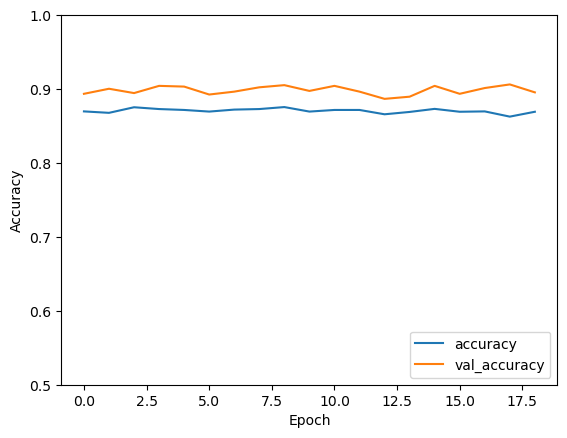

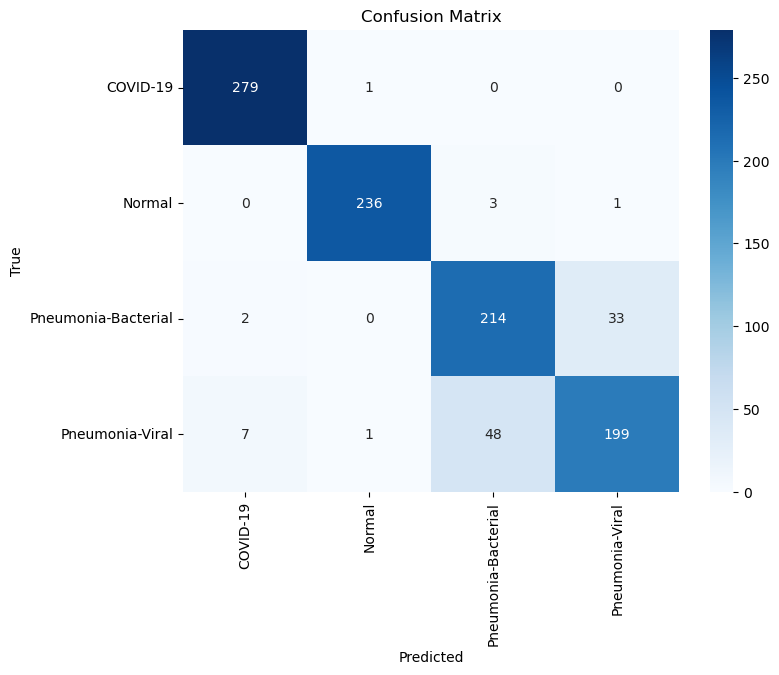

In [50]:
val_metrics()
model.save("xray_model_finer_tuned.keras")